# Exploratory Analysis for Cleaned YSET Data

Date: 06/27/2019
Add reliability over time to the code

## Unit and Data Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

In [2]:
## Import data set
cleaned_filepath = 'YSET_Dec2008_Dec2019_cleaned20190531.csv'
key_filepath = 'YSET Database_ALL YSETs_2008-Feb 2019.csv'

key = pd.read_csv(key_filepath)
#key = key.set_index('key')

df = pd.read_csv(cleaned_filepath)
df.head()

FileNotFoundError: File b'YSET Database_ALL YSETs_2008-Feb 2019.csv' does not exist

In [3]:
df.shape

(32896, 394)

## Basic Exploration of Data

### Risk Factor

In [4]:
df['y_TotalFactors'] = pd.to_numeric(df['y_TotalFactors'], downcast = 'integer', errors = 'coerce')
df.loc[(df['y_TotalFactors'] == 88), 'y_TotalFactors'] = np.nan
df['y_TotalFactors'].describe(percentiles = [.25, .5, .75])

count    31902.000000
mean         3.379945
std          2.732965
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max          9.000000
Name: y_TotalFactors, dtype: float64

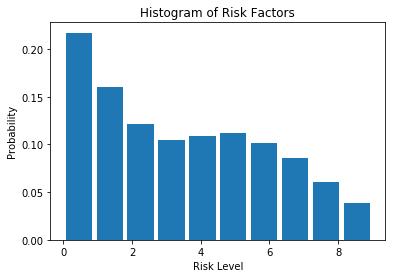

In [5]:
plt.hist(df['y_TotalFactors'],density = True, rwidth=0.85)
plt.xlabel('Risk Level')
plt.ylabel('Probability')
plt.title('Histogram of Risk Factors')
plt.show()

### Unique ID

In [4]:
df['UniqueID'] = pd.to_numeric(df['UniqueID'], downcast = 'integer', errors = 'coerce')

In [5]:
# Number of unique individuals who have ever submitted a response 

df.UniqueID.value_counts().describe()

count    22567.000000
mean         1.457704
std          0.717323
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: UniqueID, dtype: float64

In [6]:
# IDs with different numbers of snapshots

ID_6 = df.UniqueID.value_counts()[df.UniqueID.value_counts() == 6].index
ID_5 = df.UniqueID.value_counts()[df.UniqueID.value_counts() == 5].index
ID_4 = df.UniqueID.value_counts()[df.UniqueID.value_counts() == 4].index
ID_3 = df.UniqueID.value_counts()[df.UniqueID.value_counts() == 3].index
ID_2 = df.UniqueID.value_counts()[df.UniqueID.value_counts() == 2].index
ID_1 = df.UniqueID.value_counts()[df.UniqueID.value_counts() == 1].index

## Cleaning up outlier entries in data

### Section IJ

In [7]:
df['Score_ScaleIJ_new'] = 0

for col in df.loc[:,'ij40_6mos_combo':'ij56_ever_combo'].columns.tolist():
    
    df[col] = pd.to_numeric(df[col], downcast = 'integer', errors = 'coerce')
    df = df[df[col] != -1]
    df = df[df[col] != 11]# drop

    df.loc[(df[col] == 99), col] = np.nan
    df.loc[(df[col] == 9), col] = np.nan
    
    df['Score_ScaleIJ_new'] += df[col]
    
    #print(df[col].value_counts())

### Section Norms (Groups of Friends)

In [8]:
df['EG85a']=pd.to_numeric(df['EG85a'], downcast = 'integer', errors = 'coerce')
df['EG80']=pd.to_numeric(df['EG80'], downcast = 'integer', errors = 'coerce')
df['EG81']=pd.to_numeric(df['EG81'], downcast = 'integer', errors = 'coerce')
df['EG84']=pd.to_numeric(df['EG84'], downcast = 'integer', errors = 'coerce')

In [9]:
# Removing rows w invalid inputs 

# EG80
df = df[df.EG80 != -1]
df = df[df.EG80 != 3]
df = df[df.EG80 != 2]
df = df[df.EG80 != 11]
df = df[df.EG80 != 33]# drop

df.loc[(df['EG80'] == 99), 'EG80'] = np.nan
df.loc[(df['EG80'] == 999), 'EG80'] = np.nan
df.loc[(df['EG80'] == 9), 'EG80'] = np.nan


# EG81
df = df[df.EG81 != 11]# drop

df.loc[(df['EG81'] == 99), 'EG81'] = np.nan
df.loc[(df['EG81'] == 999), 'EG81'] = np.nan
df.loc[(df['EG81'] == 9), 'EG81'] = np.nan

# EG84
df.loc[(df['EG84'] == 99), 'EG84'] = np.nan
df.loc[(df['EG84'] == 999), 'EG84'] = np.nan
df.loc[(df['EG84'] == 9), 'EG84'] = np.nan

# EG85a
df.loc[(df['EG85a'] == 99), 'EG85a'] = np.nan
df.loc[(df['EG85a'] == 9), 'EG85a'] = np.nan


In [10]:
# Add up the scores

df['Score_ScaleNorms'] = df['EG80'] + df['EG81']+ df['EG84'] + df['EG85a']

In [11]:
df['Score_ScaleNorms'].value_counts()

0.0    18267
1.0     3563
2.0     3240
3.0     1394
4.0      402
Name: Score_ScaleNorms, dtype: int64

## Determine Reliability for Section IJ

In [12]:
#Create columns of consistency by looking at the responses to question 6 months and ever
    #not consistent if a person answered yes to 6 months but no to ever
    
df['cstcy'] = 0
for var in range(40,56):
    df['cstcy{}'.format(var)] = np.where((df['ij{}_6mos_combo'.format(var)] ==1 ) & (df['ij{}_ever_combo'.format(var)]== 0), 1, 0)
    df['cstcy'] +=  df['cstcy{}'.format(var)]

In [13]:
df['cstcy'].value_counts()

0     32322
1       412
2        62
3        33
4        15
5         6
6         2
11        1
7         1
Name: cstcy, dtype: int64

In [14]:
# function to check whether there exists inconsisteny for an ID in one problem

def check(IJ_ever, ever):
    for ans in IJ_ever:
        if (ans == 1):
            ever = True
        if ((ever == True) & (ans == 0)):         
            return False
    return True

In [36]:
# for loops to create consistency columns over time for each question

for var in range(40,57):
    df['cstcy_ovtime{}'.format(var)] = 0
    for i in range(2,7):
        for index in range(len('ID_{}'.format(i))): 
            ever = False
            exec("IJ_ever = df[(df['UniqueID'] == ID_{}[index])]['ij{}_ever_combo']".format(i,var))
            row = IJ_ever.index.tolist()[0]
            if (check(IJ_ever,ever) == False):    
                df.set_value(row,['cstcy_ovtime{}'.format(var)],1)

In [37]:
# sum all the columns for each question to an individual column 

cnames = df.loc[:,'cstcy_ovtime40':'cstcy_ovtime56'].columns.tolist()
df['cstcy_ovtime'] = 0
for col in cnames:
    df['cstcy_ovtime'] += df[col]

In [38]:
df['cstcy_ovtime'].value_counts()

0     32836
6         5
3         4
2         3
11        1
10        1
9         1
5         1
4         1
1         1
Name: cstcy_ovtime, dtype: int64

In [64]:
df[(df['UniqueID'] == ID_6[1])].index.tolist()[0]

9729

In [40]:
df[(df['UniqueID'] == ID_6[2])]

,Unnamed: 0,UniqueID,YSET_I_R,y_TotalFactors,y_DateS1_Interview,YouthStatus,Agency,GRYD_Zone,Ethnicity_Asian,Ethnicity_Black,...,cstcy_ovtime546,cstcy_ovtime542,cstcy_ovtime543,cstcy_ovtime544,cstcy_ovtime545,cstcy_ovtime556,cstcy_ovtime552,cstcy_ovtime553,cstcy_ovtime554,cstcy_ovtime555
9692,12941,14307,1.0,4.0,2010-03-17,,,5,0.0,0,...,0,0,0,0,0,0,0,0,0,0
9693,12942,14307,11.0,7.0,2011-01-24,,,5,0.0,0,...,0,0,0,0,0,0,0,0,0,0
9694,12943,14307,12.0,8.0,2011-08-16,,,5,0.0,0,...,0,0,0,0,0,0,0,0,0,0
9695,12944,14307,13.0,9.0,2012-04-27,,,5,0.0,0,...,0,0,0,0,0,0,0,0,0,0
9696,12945,14307,14.0,NaN,2012-10-30,,,5,0.0,0,...,0,0,0,0,0,0,0,0,0,0
9697,12946,14307,15.0,9.0,2013-04-25,,,5,0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Note: In the above table, we can see a significantly increasing trend in the y_total factors for ID_6[2], which means according to the GRYD's rule, he or she may have a higher probability to join the gang. However, for person ID_6[1], there  is a significantly decreasing trend. These two people received services by looking at the YSET_I_R.

## Creating Dataframes for Analysis

In [15]:
# Extracting score scales from cleaned data
df_byfac =df.loc[:,'Score_ScaleA':'Score_ScaleNorms']
df_byfac.drop(['Score_ScaleIJMissing','Score_ScaleIJWithGangMissing'],axis = 1,inplace=True)
for col in df_byfac:
     df_byfac[col] = pd.to_numeric(df_byfac[col], downcast = 'integer', errors = 'coerce')
        
df['y_DateS1_Interview'] = pd.to_datetime(df['y_DateS1_Interview'], errors='coerce')        
df_byfac['Date'] = df['y_DateS1_Interview']

df_byfac['Age'] = df['Age']
df_byfac['Score_ScaleIJ_new'] = df['Score_ScaleIJ_new']
df_byfac['UniqueID'] = df['UniqueID']

# Moving Unique ID to the front
cols = df_byfac.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_byfac = df_byfac[cols]


In [16]:
df_byfac.head()

,UniqueID,Score_ScaleA,Score_ScaleB,Score_ScaleC,Score_ScaleDE,Score_ScaleF,Score_ScaleFS,Score_ScaleG,Score_ScaleH,Score_ScaleIJ,Score_ScaleK,Score_ScaleP,Score_ScaleT,Score_ScaleNorms,Date,Age,Score_ScaleIJ_new
0,1010,12.0,11.0,4.0,15.0,17.0,NaN,8.0,15.0,2,NaN,NaN,NaN,NaN,2010-05-13,16,5.0
1,1010,13.0,7.0,0.0,11.0,17.0,NaN,5.0,6.0,5,13.0,NaN,0.0,36.0,2011-07-28,18,9.0
2,1042,12.0,10.0,4.0,13.0,21.0,NaN,17.0,26.0,6,NaN,NaN,2.0,NaN,2011-09-27,18,12.0
3,1043,19.0,15.0,1.0,14.0,24.0,NaN,18.0,24.0,10,NaN,NaN,2.0,NaN,2010-05-17,15,17.0
4,1043,13.0,9.0,1.0,13.0,19.0,NaN,13.0,15.0,10,13.0,NaN,NaN,2.0,2011-07-27,16,12.0


### WE FIGURED OUT WHEN THEY STARTED TO ASK FS QUESTIONS!!!
- We will split the data into two: one before the key date (2013-11-1, when they changed the questionnaire) and one after.

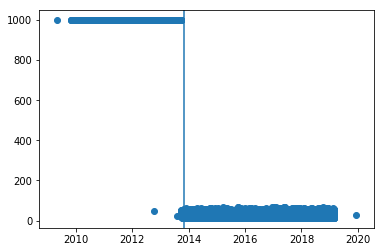

In [17]:
import time
from datetime import date

keydate = date(2013, 11, 1)

df_byfac.Score_ScaleFS[df_byfac['Score_ScaleFS'].isna()] = 999

plt.scatter(x=df_byfac.Date,y=df_byfac.Score_ScaleFS)
plt.axvline(x=keydate)
plt.show()

df_byfac.loc[(df_byfac['Score_ScaleFS'] == 999), 'Score_ScaleFS'] = np.nan


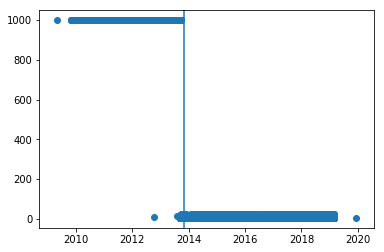

In [18]:
df_byfac.Score_ScaleP[df_byfac['Score_ScaleP'].isna()] = 999

plt.scatter(x=df_byfac.Date,y=df_byfac.Score_ScaleP)
plt.axvline(x=keydate)
plt.show()

df_byfac.loc[(df_byfac['Score_ScaleP'] == 999), 'Score_ScaleP'] = np.nan

### Split data up into "Before Keydate" and "After Keydate"

In [19]:
# Before keydate

df_bkey = df_byfac[df_byfac.Date < keydate]

# Drop questions that wasn't asked before keydate
df_bkey.drop(['Score_ScaleFS','Score_ScaleP'],axis = 1,inplace=True)

In [20]:
# After keydate 
df_akey = df_byfac[df_byfac.Date >= keydate]

## Linear Regression with Scales

### Before keydate

Things left to do:

- Model validity checking / Transformation
- **Plotting**
- Predictor selecting: mix and match?
- Explain meaning of the slopes

In [35]:
import statsmodels.api as sm

In [22]:
# list of colnames we are using as X
cnames = df_bkey.loc[:,'Score_ScaleA':'Score_ScaleH'].columns.tolist()
cnames.extend(df_bkey.loc[:,'Score_ScaleK':'Score_ScaleNorms'].columns.tolist())

df_bkey.dropna(inplace = True)

X_bkey = sm.add_constant(df_bkey[cnames])
Y_bkey= df_bkey["Score_ScaleIJ_new"]

In [23]:
X_bkey.head()

,const,Score_ScaleA,Score_ScaleB,Score_ScaleC,Score_ScaleDE,Score_ScaleF,Score_ScaleG,Score_ScaleH,Score_ScaleK,Score_ScaleT,Score_ScaleNorms
1,1.0,13.0,7.0,0.0,11.0,17.0,5.0,6.0,13.0,0.0,36.0
6,1.0,11.0,7.0,2.0,10.0,15.0,18.0,14.0,14.0,1.0,0.0
10,1.0,15.0,4.0,2.0,15.0,15.0,15.0,20.0,17.0,1.0,0.0
14,1.0,16.0,5.0,5.0,13.0,18.0,15.0,11.0,20.0,0.0,3.0
22,1.0,11.0,10.0,2.0,11.0,20.0,12.0,15.0,16.0,0.0,0.0


In [97]:
# Note the difference in argument order
model_bkey = sm.OLS(Y_bkey, X_bkey).fit()
predictions_bkey = model_bkey.predict(X_bkey) # make the predictions by the model

# Print out the statistics
model_bkey.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     615.8
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:59:51   Log-Likelihood:                -14070.
No. Observations:                5225   AIC:                         2.816e+04
Df Residuals:                    5214   BIC:                         2.823e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.5634      0.229    -24.305      0.000      -6.012      -5.115
Score_ScaleA        -0.0031      0.017     -0.181      0.856      -0.036       0.030
Score_ScaleB         0.1228      0.019      6.421      0.000       0.085       0.160
Score_ScaleC         0.2905      0.033      8.773      0.000       0.226       0.355
Score_ScaleDE        0.0685      0.020      3.383      0.001       0.029       0.108
Score_ScaleF         0.2005      0.016     12.326      0.000       0.169       0.232
Score_ScaleG         0.0338      0.013      2.663      0.008       0.009       0.059
Score_ScaleH         0.3155      0.015     21.463      0.000       0.287       0.344
Score_ScaleK         0.0283      0.010      2.702      0.007       0.008       0.049
Score_ScaleT         0.4981      0.089      5.570      0.000       0.323       0.673
Score_ScaleNorms     1.3307      0.058     22.762      0.000       1.216       1.445
==============================================================================
Omnibus:                      446.686   Durbin-Watson:                   1.691
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              839.523
Skew:                           0.590   Prob(JB):                    5.01e-183
Kurtosis:                       4.570   Cond. No.                         170.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Simple Linear Regressions of Significant Sections to IJ Before Keydate

#### Running Simple Linear Regression on Each 'Feature' 

In [24]:
#Score_ScaleB vs Score_ScaleIJ_new
X_bkey1 = df_bkey['Score_ScaleB']
y_bkey1= df_bkey["Score_ScaleIJ_new"]

# Note the difference in argument order
model_bkey = sm.OLS(y_bkey1, X_bkey1).fit()
predictions_bkey = model_bkey.predict(X_bkey1) # make the predictions by the model

# Print out the statistics
model_bkey.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     9864.
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:33:24   Log-Likelihood:                -17325.
No. Observations:                5789   AIC:                         3.465e+04
Df Residuals:                    5788   BIC:                         3.466e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Score_ScaleB     0.8603      0.009     99.320      0.000       0.843       0.877
==============================================================================
Omnibus:                      621.433   Durbin-Watson:                   1.541
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              937.616
Skew:                           0.798   Prob(JB):                    2.51e-204
Kurtosis:                       4.159   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
#Score_ScaleC vs Score_ScaleIJ_new
X_bkey2 = df_bkey['Score_ScaleC']
y_bkey2= df_bkey["Score_ScaleIJ_new"]

# Note the difference in argument order
model_bkey = sm.OLS(y_bkey2, X_bkey2).fit()
predictions_bkey = model_bkey.predict(X_bkey2) # make the predictions by the model

# Print out the statistics
model_bkey.summary()
 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     9962.
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:33:28   Log-Likelihood:                -17307.
No. Observations:                5789   AIC:                         3.462e+04
Df Residuals:                    5788   BIC:                         3.462e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Score_ScaleC     1.6951      0.017     99.811      0.000       1.662       1.728
==============================================================================
Omnibus:                      663.279   Durbin-Watson:                   1.549
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1009.846
Skew:                           0.837   Prob(JB):                    5.19e-220
Kurtosis:                       4.176   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
#Score_ScaleDE vs Score_ScaleIJ_new
X_bkey3 = df_bkey['Score_ScaleDE']
y_bkey3= df_bkey["Score_ScaleIJ_new"]

# Note the difference in argument order
model_bkey = sm.OLS(y_bkey3, X_bkey3).fit()
predictions_bkey = model_bkey.predict(X_bkey3) # make the predictions by the model

# Print out the statistics
model_bkey.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                 1.106e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:33:32   Log-Likelihood:                -17112.
No. Observations:                5789   AIC:                         3.423e+04
Df Residuals:                    5788   BIC:                         3.423e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Score_ScaleDE     0.4901      0.005    105.165      0.000       0.481       0.499
==============================================================================
Omnibus:                      980.742   Durbin-Watson:                   1.510
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1764.231
Skew:                           1.076   Prob(JB):                         0.00
Kurtosis:                       4.639   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
#Score_ScaleF vs Score_ScaleIJ_new
X_bkey4 = df_bkey['Score_ScaleF']
y_bkey4= df_bkey["Score_ScaleIJ_new"]

# Note the difference in argument order
model_bkey = sm.OLS(y_bkey4, X_bkey4).fit()
predictions_bkey = model_bkey.predict(X_bkey4) # make the predictions by the model

# Print out the statistics
model_bkey.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                 1.174e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:33:34   Log-Likelihood:                -16997.
No. Observations:                5789   AIC:                         3.400e+04
Df Residuals:                    5788   BIC:                         3.400e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Score_ScaleF     0.3658      0.003    108.342      0.000       0.359       0.372
==============================================================================
Omnibus:                      972.320   Durbin-Watson:                   1.508
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1719.399
Skew:                           1.077   Prob(JB):                         0.00
Kurtosis:                       4.578   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
#Score_ScaleG vs Score_ScaleIJ_new
X_bkey5= df_bkey['Score_ScaleG']
y_bkey5= df_bkey["Score_ScaleIJ_new"]

# Note the difference in argument order
model_bkey = sm.OLS(y_bkey5, X_bkey5).fit()
predictions_bkey = model_bkey.predict(X_bkey5) # make the predictions by the model

# Print out the statistics
model_bkey.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     9998.
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:33:34   Log-Likelihood:                -17300.
No. Observations:                5789   AIC:                         3.460e+04
Df Residuals:                    5788   BIC:                         3.461e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Score_ScaleG     0.4889      0.005     99.988      0.000       0.479       0.498
==============================================================================
Omnibus:                      792.941   Durbin-Watson:                   1.531
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1342.546
Skew:                           0.917   Prob(JB):                    2.95e-292
Kurtosis:                       4.483   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
#Score_ScaleH vs Score_ScaleIJ_new
X_bkey6= df_bkey['Score_ScaleH']
y_bkey6= df_bkey["Score_ScaleIJ_new"]

# Note the difference in argument order
model_bkey = sm.OLS(y_bkey6, X_bkey6).fit()
predictions_bkey = model_bkey.predict(X_bkey6) # make the predictions by the model

# Print out the statistics
model_bkey.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                 1.429e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:33:35   Log-Likelihood:                -16603.
No. Observations:                5789   AIC:                         3.321e+04
Df Residuals:                    5788   BIC:                         3.322e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Score_ScaleH     0.5525      0.005    119.559      0.000       0.543       0.562
==============================================================================
Omnibus:                      652.129   Durbin-Watson:                   1.591
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              946.415
Skew:                           0.853   Prob(JB):                    3.08e-206
Kurtosis:                       4.006   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
#Score_ScaleK vs Score_ScaleIJ_new
X_bkey7 = df_bkey['Score_ScaleK']
y_bkey7= df_bkey["Score_ScaleIJ_new"]

# Note the difference in argument order
model_bkey = sm.OLS(y_bkey7, X_bkey7).fit()
predictions_bkey = model_bkey.predict(X_bkey7) # make the predictions by the model

# Print out the statistics
model_bkey.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     9329.
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:33:36   Log-Likelihood:                -17425.
No. Observations:                5789   AIC:                         3.485e+04
Df Residuals:                    5788   BIC:                         3.486e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Score_ScaleK     0.3656      0.004     96.589      0.000       0.358       0.373
==============================================================================
Omnibus:                      823.940   Durbin-Watson:                   1.525
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5433.197
Skew:                           0.503   Prob(JB):                         0.00
Kurtosis:                       7.638   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
#Score_ScaleT vs Score_ScaleIJ_new
X_bkey8 = df_bkey['Score_ScaleT']
y_bkey8= df_bkey["Score_ScaleIJ_new"]

# Note the difference in argument order
model_bkey = sm.OLS(y_bkey8, X_bkey8).fit()
predictions_bkey = model_bkey.predict(X_bkey8) # make the predictions by the model

# Print out the statistics
model_bkey.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     2715.
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:33:37   Log-Likelihood:                -19091.
No. Observations:                5789   AIC:                         3.818e+04
Df Residuals:                    5788   BIC:                         3.819e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Score_ScaleT     6.5159      0.125     52.110      0.000       6.271       6.761
==============================================================================
Omnibus:                      241.894   Durbin-Watson:                   1.129
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              309.884
Skew:                           0.442   Prob(JB):                     5.12e-68
Kurtosis:                       3.710   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
#Score_ScaleNorms vs Score_ScaleIJ_new
X_bkey9 = df_bkey['Score_ScaleNorms']
y_bkey9= df_bkey["Score_ScaleIJ_new"]

# Note the difference in argument order
model_bkey = sm.OLS(y_bkey9, X_bkey9).fit()
predictions_bkey = model_bkey.predict(X_bkey9) # make the predictions by the model

# Print out the statistics
model_bkey.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     16.31
Date:                Wed, 26 Jun 2019   Prob (F-statistic):           5.45e-05
Time:                        16:33:37   Log-Likelihood:                -20196.
No. Observations:                5789   AIC:                         4.039e+04
Df Residuals:                    5788   BIC:                         4.040e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Score_ScaleNorms     0.0073      0.002      4.038      0.000       0.004       0.011
==============================================================================
Omnibus:                      727.906   Durbin-Watson:                   0.675
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1079.306
Skew:                           0.925   Prob(JB):                    4.28e-235
Kurtosis:                       4.024   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

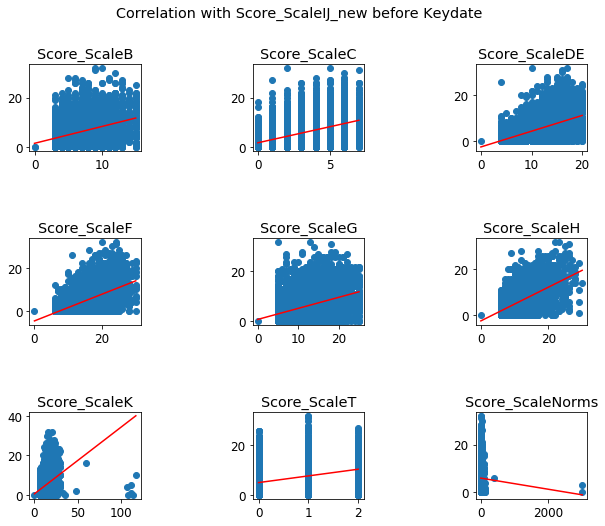

In [37]:
font = {'family' : 'DejaVu Sans',
  'size' : 12}
plt.rc('font', **font)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8

#Score_ScaleB vs Score_ScaleIJ_new
ax0 = plt.subplot(331)
ax0.get_xaxis().set_label_position('bottom')
ax0.set_title("Score_ScaleB")
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_bkey1,y_bkey1)
mn=np.min(X_bkey1)
mx=np.max(X_bkey1)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
ax0.scatter(X_bkey1,y_bkey1)
ax0.plot(x1,y1,'-r')

#Score_ScaleC vs Score_ScaleIJ_new
ax1 = plt.subplot(332)
ax1.get_xaxis().set_label_position('bottom')
ax1.set_title("Score_ScaleC")
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_bkey2,y_bkey2)
mn=np.min(X_bkey2)
mx=np.max(X_bkey2)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
ax1.scatter(X_bkey2,y_bkey2)
ax1.plot(x1,y1,'-r')

#Score_ScaleDE vs Score_ScaleIJ_new
ax2 = plt.subplot(333)
ax2.get_xaxis().set_label_position('bottom')
ax2.set_title("Score_ScaleDE")
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_bkey3,y_bkey3)
mn=np.min(X_bkey3)
mx=np.max(X_bkey3)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
ax2.scatter(X_bkey3,y_bkey3)
ax2.plot(x1,y1,'-r')

#Score_ScaleF vs Score_ScaleIJ_new
ax3 = plt.subplot(334)
ax3.get_xaxis().set_label_position('bottom')
ax3.set_title("Score_ScaleF")
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_bkey4,y_bkey4)
mn=np.min(X_bkey4)
mx=np.max(X_bkey4)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
ax3.scatter(X_bkey4,y_bkey4)
ax3.plot(x1,y1,'-r')

#Score_ScaleG vs Score_ScaleIJ_new
ax4 = plt.subplot(335)
ax4.get_xaxis().set_label_position('bottom')
ax4.set_title("Score_ScaleG")
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_bkey5,y_bkey5)
mn=np.min(X_bkey5)
mx=np.max(X_bkey5)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
ax4.scatter(X_bkey5,y_bkey5)
ax4.plot(x1,y1,'-r')

#Score_ScaleH vs Score_ScaleIJ_new
ax5 = plt.subplot(336)
ax5.get_xaxis().set_label_position('bottom')
ax5.set_title("Score_ScaleH")
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_bkey6,y_bkey6)
mn=np.min(X_bkey6)
mx=np.max(X_bkey6)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
ax5.scatter(X_bkey6,y_bkey6)
ax5.plot(x1,y1,'-r')

#Score_ScaleK vs Score_ScaleIJ_new
ax6 = plt.subplot(337)
ax6.get_xaxis().set_label_position('bottom')
ax6.set_title("Score_ScaleK")
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_bkey7,y_bkey7)
mn=np.min(X_bkey7)
mx=np.max(X_bkey7)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
ax6.scatter(X_bkey7,y_bkey7)
ax6.plot(x1,y1,'-r')

#Score_ScaleT vs Score_ScaleIJ_new
ax7 = plt.subplot(338)
ax7.get_xaxis().set_label_position('bottom')
ax7.set_title("Score_ScaleT")
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_bkey8,y_bkey8)
mn=np.min(X_bkey8)
mx=np.max(X_bkey8)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
ax7.scatter(X_bkey8,y_bkey8)
ax7.plot(x1,y1,'-r')

#Score_ScaleNorms vs Score_ScaleIJ_new
ax8 = plt.subplot(339)
ax8.get_xaxis().set_label_position('bottom')
ax8.set_title("Score_ScaleNorms")
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_bkey9,y_bkey9)
mn=np.min(X_bkey9)
mx=np.max(X_bkey9)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
ax8.scatter(X_bkey9,y_bkey9)
ax8.plot(x1,y1,'-r')

plt.subplots_adjust(hspace=1, wspace=1) 
plt.suptitle("Correlation with Score_ScaleIJ_new before Keydate")

plt.show()


### After keydate

#### Modeling

In [38]:
import statsmodels.api as sm

In [39]:
cnames_all = df_akey.loc[:,'Score_ScaleA':'Score_ScaleH'].columns.tolist()
cnames_all.extend(df_bkey.loc[:,'Score_ScaleK':'Score_ScaleNorms'].columns.tolist())
df_akey.dropna(inplace = True)

X_akey = sm.add_constant(df_akey[cnames_all])
Y_akey = df_akey["Score_ScaleIJ_new"]

In [40]:
X_akey.describe()

,const,Score_ScaleA,Score_ScaleB,Score_ScaleC,Score_ScaleDE,Score_ScaleF,Score_ScaleFS,Score_ScaleG,Score_ScaleH,Score_ScaleK,Score_ScaleT,Score_ScaleNorms
count,20882.0,20882.000000,20882.000000,20882.000000,20882.000000,20882.000000,20882.000000,20882.000000,20882.000000,20882.000000,20882.000000,20882.000000
mean,1.0,14.086103,6.078345,2.951298,12.077675,16.782013,31.275213,11.500287,9.572982,15.311656,0.321856,1.445791
std,0.0,4.590043,3.219504,1.783818,4.208459,5.162406,9.835960,4.665008,3.776725,5.125510,0.585647,5.787114
min,1.0,6.000000,3.000000,0.000000,4.000000,6.000000,13.000000,5.000000,5.000000,6.000000,0.000000,-4.000000
25%,1.0,10.000000,3.000000,2.000000,9.000000,13.000000,24.000000,8.000000,7.000000,12.000000,0.000000,0.000000
50%,1.0,14.000000,5.000000,3.000000,12.000000,17.000000,31.000000,11.000000,8.000000,15.000000,0.000000,0.000000
75%,1.0,17.000000,9.000000,4.000000,16.000000,20.000000,38.000000,15.000000,11.000000,19.000000,1.000000,1.000000
max,1.0,30.000000,15.000000,7.000000,20.000000,30.000000,65.000000,25.000000,30.000000,111.000000,2.000000,36.000000


In [41]:
# Note the difference in argument order
model_akey = sm.OLS(Y_akey, X_akey).fit()
predictions_akey = model_akey.predict(X_akey) # make the predictions by the model

# Print out the statistics
model_akey.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     2114.
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:35:18   Log-Likelihood:                -55665.
No. Observations:               20882   AIC:                         1.114e+05
Df Residuals:                   20870   BIC:                         1.114e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -6.9003      0.104    -66.058      0.000      -7.105      -6.696
Score_ScaleA         0.0062      0.008      0.766      0.444      -0.010       0.022
Score_ScaleB         0.1219      0.010     12.324      0.000       0.103       0.141
Score_ScaleC         0.4146      0.016     25.231      0.000       0.382       0.447
Score_ScaleDE        0.0447      0.009      4.765      0.000       0.026       0.063
Score_ScaleF         0.1824      0.007     24.496      0.000       0.168       0.197
Score_ScaleFS        0.0040      0.003      1.352      0.176      -0.002       0.010
Score_ScaleG         0.0118      0.007      1.703      0.089      -0.002       0.025
Score_ScaleH         0.5190      0.008     64.592      0.000       0.503       0.535
Score_ScaleK         0.0159      0.007      2.312      0.021       0.002       0.029
Score_ScaleT         0.9164      0.046     20.063      0.000       0.827       1.006
Score_ScaleNorms     0.0042      0.004      1.001      0.317      -0.004       0.012
==============================================================================
Omnibus:                     2752.654   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7465.314
Skew:                           0.730   Prob(JB):                         0.00
Kurtosis:                       5.539   Cond. No.                         207.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Note: These two models before_keydate and after_keydate are almost consistent because the predictor Score_ScaleA is both statistically insignificant in both models. Also, according to Jerry's PCA model, Question t38 and t39 show dominant effects. In both of our models, predictor Score_ScaleT has rather bigger coefficients, which means they are contributing more to the models. However, in after_keydate 

#### Plotting

In [42]:
import seaborn as sns
from scipy import stats

#### Residual plot 

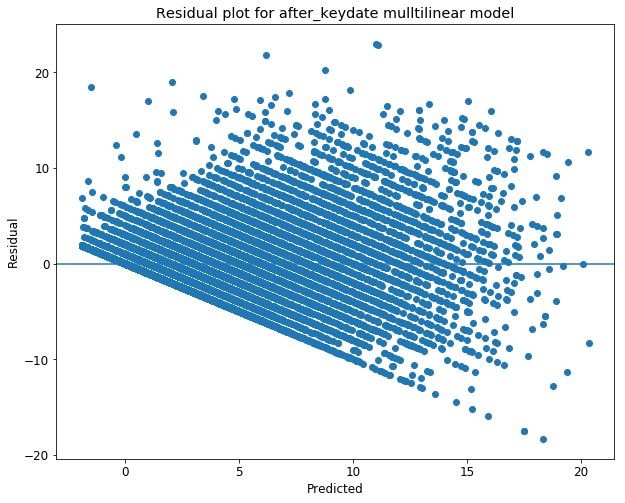

In [43]:
#create residual plot for after_keydate mulltilinear models 

difference = Y_akey - predictions_akey
plt.scatter(predictions_akey,difference)
plt.axhline(y=0)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residual plot for after_keydate mulltilinear model')
plt.show()

#### Linear regression plot between the sum of other scores and score IJ

In [44]:
#create x as the sum of other scores
df_akey['Score_Sum'] = 0

for col in cnames_all:
    df_akey['Score_Sum'] += df_akey[col]

In [45]:
#build linear regression models

X_akeysum = df_akey['Score_Sum']
Y_akeysum= df_akey["Score_ScaleIJ_new"]

In [46]:
X_akeysum.head(10)

4514     85.0
4620     65.0
4627     90.0
4632    109.0
4635     73.0
4636    165.0
4637    119.0
4638    153.0
4639    162.0
4640    106.0
Name: Score_Sum, dtype: float64

In [47]:
Y_akeysum.shape

(20882,)

In [48]:
# Note the difference in argument order
model_akeysum = sm.OLS(Y_akeysum, X_akeysum).fit()
predictions_akeysum = model_akeysum.predict(X_akeysum) # make the predictions by the model

# Print out the statistics
model_akeysum.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                 2.793e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:35:24   Log-Likelihood:                -60757.
No. Observations:               20882   AIC:                         1.215e+05
Df Residuals:                   20881   BIC:                         1.215e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Score_Sum      0.0409      0.000    167.116      0.000       0.040       0.041
==============================================================================
Omnibus:                     5980.059   Durbin-Watson:                   1.588
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16220.568
Skew:                           1.538   Prob(JB):                         0.00
Kurtosis:                       6.029   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

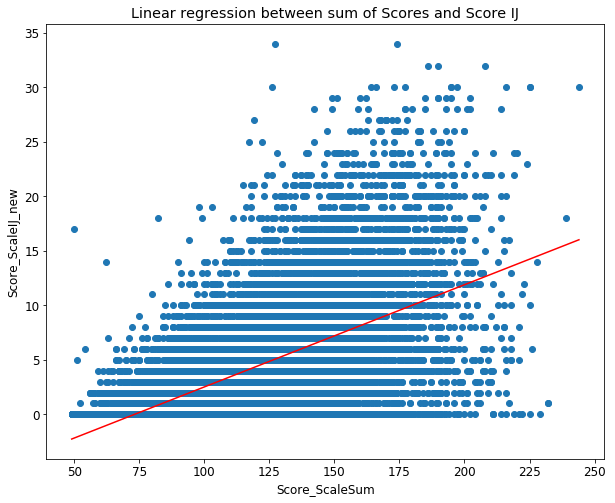

In [49]:
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeysum,Y_akeysum)
mn=np.min(X_akeysum)
mx=np.max(X_akeysum)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.scatter(X_akeysum,Y_akeysum)
plt.plot(x1,y1,'-r')
plt.xlabel('Score_ScaleSum')
plt.ylabel('Score_ScaleIJ_new')
plt.title('Linear regression between sum of Scores and Score IJ')
plt.show()

#### Several Linear regression between each 'Feature' and Score IJ

In [50]:
#build linear regression models for Score B

X_akeyB = df_akey['Score_ScaleB']
Y_akey= df_akey["Score_ScaleIJ_new"]

model_akeyB = sm.OLS(Y_akey, X_akeyB).fit()
predictions_akeyB = model_akeyB.predict(X_akeyB) # make the predictions by the model

model_akeyB.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                 2.478e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:35:25   Log-Likelihood:                -61452.
No. Observations:               20882   AIC:                         1.229e+05
Df Residuals:                   20881   BIC:                         1.229e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Score_ScaleB     0.7270      0.005    157.429      0.000       0.718       0.736
==============================================================================
Omnibus:                     4415.926   Durbin-Watson:                   1.622
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10011.250
Skew:                           1.206   Prob(JB):                         0.00
Kurtosis:                       5.385   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
#build linear regression models for Score C

X_akeyC = df_akey['Score_ScaleC']
Y_akey= df_akey["Score_ScaleIJ_new"]

model_akeyC = sm.OLS(Y_akey, X_akeyC).fit()
predictions_akeyC = model_akeyC.predict(X_akeyC) # make the predictions by the model

model_akeyC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                 2.810e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:35:25   Log-Likelihood:                -60720.
No. Observations:               20882   AIC:                         1.214e+05
Df Residuals:                   20881   BIC:                         1.215e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Score_ScaleC     1.4908      0.009    167.621      0.000       1.473       1.508
==============================================================================
Omnibus:                     4742.599   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11956.202
Skew:                           1.244   Prob(JB):                         0.00
Kurtosis:                       5.747   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
#build linear regression models for Score DE

X_akeyDE = df_akey['Score_ScaleDE']
Y_akey= df_akey["Score_ScaleIJ_new"]

model_akeyDE = sm.OLS(Y_akey, X_akeyDE).fit()
predictions_akeyDE = model_akeyDE.predict(X_akeyDE) # make the predictions by the model

model_akeyDE.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                 2.703e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:35:26   Log-Likelihood:                -60950.
No. Observations:               20882   AIC:                         1.219e+05
Df Residuals:                   20881   BIC:                         1.219e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Score_ScaleDE     0.3986      0.002    164.420      0.000       0.394       0.403
==============================================================================
Omnibus:                     6040.881   Durbin-Watson:                   1.613
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17247.123
Skew:                           1.529   Prob(JB):                         0.00
Kurtosis:                       6.236   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
#build linear regression models for Score F

X_akeyF = df_akey['Score_ScaleF']
Y_akey= df_akey["Score_ScaleIJ_new"]

model_akeyF = sm.OLS(Y_akey, X_akeyF).fit()
predictions_akeyF = model_akeyB.predict(X_akeyF) # make the predictions by the model

model_akeyF.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                 2.773e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:35:26   Log-Likelihood:                -60799.
No. Observations:               20882   AIC:                         1.216e+05
Df Residuals:                   20881   BIC:                         1.216e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Score_ScaleF     0.2920      0.002    166.522      0.000       0.289       0.295
==============================================================================
Omnibus:                     6078.188   Durbin-Watson:                   1.602
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17189.566
Skew:                           1.544   Prob(JB):                         0.00
Kurtosis:                       6.197   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
#build linear regression models for Score FS

X_akeyFS = df_akey['Score_ScaleFS']
Y_akey= df_akey["Score_ScaleIJ_new"]

model_akeyFS = sm.OLS(Y_akey, X_akeyFS).fit()
predictions_akeyFS = model_akeyFS.predict(X_akeyFS) # make the predictions by the model

model_akeyFS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                 1.985e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:35:27   Log-Likelihood:                -62646.
No. Observations:               20882   AIC:                         1.253e+05
Df Residuals:                   20881   BIC:                         1.253e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Score_ScaleFS     0.1445      0.001    140.885      0.000       0.143       0.147
==============================================================================
Omnibus:                     5347.286   Durbin-Watson:                   1.604
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12925.283
Skew:                           1.425   Prob(JB):                         0.00
Kurtosis:                       5.594   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
#build linear regression models for Score H

X_akeyH = df_akey['Score_ScaleH']
Y_akey= df_akey["Score_ScaleIJ_new"]

model_akeyH = sm.OLS(Y_akey, X_akeyH).fit()
predictions_akeyH = model_akeyH.predict(X_akeyH) # make the predictions by the model

model_akeyH.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                 3.581e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:35:27   Log-Likelihood:                -59193.
No. Observations:               20882   AIC:                         1.184e+05
Df Residuals:                   20881   BIC:                         1.184e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Score_ScaleH     0.5242      0.003    189.246      0.000       0.519       0.530
==============================================================================
Omnibus:                     4921.708   Durbin-Watson:                   1.609
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11265.154
Skew:                           1.337   Prob(JB):                         0.00
Kurtosis:                       5.408   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
#build linear regression models for Score K

X_akeyK = df_akey['Score_ScaleK']
Y_akey= df_akey["Score_ScaleIJ_new"]

model_akeyK = sm.OLS(Y_akey, X_akeyK).fit()
predictions_akeyK = model_akeyK.predict(X_akeyK) # make the predictions by the model

model_akeyK.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                 2.459e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:35:28   Log-Likelihood:                -61496.
No. Observations:               20882   AIC:                         1.230e+05
Df Residuals:                   20881   BIC:                         1.230e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Score_ScaleK     0.3091      0.002    156.810      0.000       0.305       0.313
==============================================================================
Omnibus:                     5658.707   Durbin-Watson:                   1.605
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15278.799
Skew:                           1.453   Prob(JB):                         0.00
Kurtosis:                       6.018   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
#build linear regression models for Score T

X_akeyT = df_akey['Score_ScaleT']
Y_akey= df_akey["Score_ScaleIJ_new"]

model_akeyT = sm.OLS(Y_akey, X_akeyT).fit()
predictions_akeyT = model_akeyT.predict(X_akeyT) # make the predictions by the model

model_akeyT.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                 1.032e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:35:28   Log-Likelihood:                -65429.
No. Observations:               20882   AIC:                         1.309e+05
Df Residuals:                   20881   BIC:                         1.309e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Score_ScaleT     5.8413      0.058    101.576      0.000       5.729       5.954
==============================================================================
Omnibus:                     2881.091   Durbin-Watson:                   1.281
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6131.371
Skew:                           0.838   Prob(JB):                         0.00
Kurtosis:                       5.058   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
#build linear regression models for Score Norms

X_akeyNorms = df_akey['Score_ScaleNorms']
Y_akey= df_akey["Score_ScaleIJ_new"]

model_akeyNorms = sm.OLS(Y_akey, X_akeyNorms).fit()
predictions_akeyNorms = model_akeyNorms.predict(X_akeyNorms) # make the predictions by the model

model_akeyNorms.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     667.7
Date:                Wed, 26 Jun 2019   Prob (F-statistic):          5.84e-145
Time:                        16:35:38   Log-Likelihood:                -69293.
No. Observations:               20882   AIC:                         1.386e+05
Df Residuals:                   20881   BIC:                         1.386e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Score_ScaleNorms     0.2003      0.008     25.841      0.000       0.185       0.216
==============================================================================
Omnibus:                     4262.055   Durbin-Watson:                   0.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9069.771
Skew:                           1.195   Prob(JB):                         0.00
Kurtosis:                       5.171   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

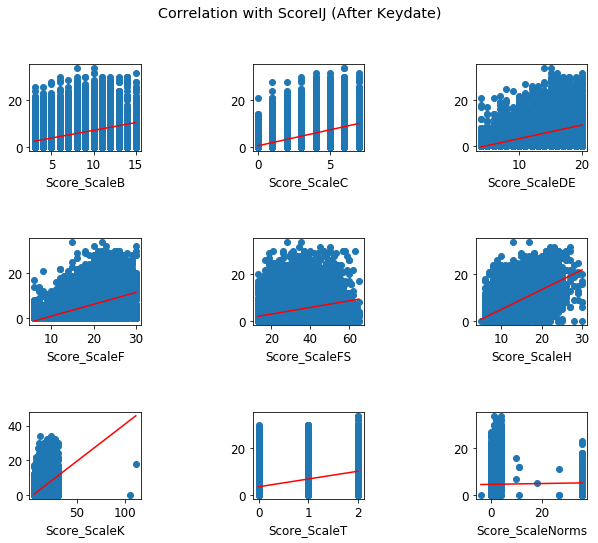

In [66]:
font = {'family' : 'DejaVu Sans',
  'size' : 12}
plt.rc('font', **font)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8

#Score_ScaleB vs Score_ScaleIJ_new
ax0 = plt.subplot(331)
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeyB,Y_akey)
mn0=np.min(X_akeyB)
mx0=np.max(X_akeyB)
x0=np.linspace(mn0,mx0,500)
y0=gradient*x0+intercept
ax0.scatter(X_akeyB,Y_akey)
ax0.plot(x0,y0,'-r')
ax0.set_xlabel('Score_ScaleB')

#Score_ScaleC vs Score_ScaleIJ_new
ax1 = plt.subplot(332)
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeyC,Y_akey)
mn1=np.min(X_akeyC)
mx1=np.max(X_akeyC)
x1=np.linspace(mn1,mx1,500)
y1=gradient*x1+intercept
ax1.scatter(X_akeyC,Y_akey)
ax1.plot(x1,y1,'-r')
ax1.set_xlabel('Score_ScaleC')

#Score_ScaleDE vs Score_ScaleIJ_new
ax2 = plt.subplot(333)
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeyDE,Y_akey)
mn2=np.min(X_akeyDE)
mx2=np.max(X_akeyDE)
x2=np.linspace(mn2,mx2,500)
y2=gradient*x2+intercept
ax2.scatter(X_akeyDE,Y_akey)
ax2.plot(x2,y2,'-r')
ax2.set_xlabel('Score_ScaleDE')

#Score_ScaleF vs Score_ScaleIJ_new
ax3 = plt.subplot(334)
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeyF,Y_akey)
mn3=np.min(X_akeyF)
mx3=np.max(X_akeyF)
x3=np.linspace(mn3,mx3,500)
y3=gradient*x3+intercept
ax3.scatter(X_akeyF,Y_akey)
ax3.plot(x3,y3,'-r')
ax3.set_xlabel('Score_ScaleF')

#Score_ScaleFS vs Score_ScaleIJ_new
ax4 = plt.subplot(335)
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeyFS,Y_akey)
mn4=np.min(X_akeyFS)
mx4=np.max(X_akeyFS)
x4=np.linspace(mn4,mx4,500)
y4=gradient*x4+intercept
ax4.scatter(X_akeyFS,Y_akey)
ax4.plot(x4,y4,'-r')
ax4.set_xlabel('Score_ScaleFS')

#Score_ScaleH vs Score_ScaleIJ_new
ax5 = plt.subplot(336)
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeyH,Y_akey)
mn5=np.min(X_akeyH)
mx5=np.max(X_akeyH)
x5=np.linspace(mn5,mx5,500)
y5=gradient*x5+intercept
ax5.scatter(X_akeyH,Y_akey)
ax5.plot(x5,y5,'-r')
ax5.set_xlabel('Score_ScaleH')

#Score_ScaleK vs Score_ScaleIJ_new
ax6 = plt.subplot(337)
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeyK,Y_akey)
mn6=np.min(X_akeyK)
mx6=np.max(X_akeyK)
x6=np.linspace(mn6,mx6,500)
y6=gradient*x6+intercept
ax6.scatter(X_akeyK,Y_akey)
ax6.plot(x6,y6,'-r')
ax6.set_xlabel('Score_ScaleK')

#Score_ScaleT vs Score_ScaleIJ_new
ax7 = plt.subplot(338)
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeyT,Y_akey)
mn7=np.min(X_akeyT)
mx7=np.max(X_akeyT)
x7=np.linspace(mn7,mx7,500)
y7=gradient*x7+intercept
ax7.scatter(X_akeyT,Y_akey)
ax7.plot(x7,y7,'-r')
ax7.set_xlabel('Score_ScaleT')

#Score_ScaleNorms vs Score_ScaleIJ_new
ax8 = plt.subplot(339)
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeyNorms,Y_akey)
mn8=np.min(X_akeyNorms)
mx8=np.max(X_akeyNorms)
x8=np.linspace(mn8,mx8,500)
y8=gradient*x8+intercept
ax8.scatter(X_akeyNorms,Y_akey)
ax8.plot(x8,y8,'-r')
ax8.set_xlabel('Score_ScaleNorms')

plt.subplots_adjust(wspace = 1, hspace= 1) 
plt.suptitle("Correlation with ScoreIJ (After Keydate)")
plt.show()

#### Note: The above graphs represent the correlation relationship between the significant predictors shown in the after_keydate models and the ScoreIJ (our outcome variable)

In [60]:
# Note the difference in argument order
model_akeyB = sm.OLS(Y_akey, X_akeyB).fit()
predictions_akeyB = model_akeyB.predict(X_akeyB) # make the predictions by the model

# Print out the statistics
model_akeyB.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                 2.478e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:35:41   Log-Likelihood:                -61452.
No. Observations:               20882   AIC:                         1.229e+05
Df Residuals:                   20881   BIC:                         1.229e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Score_ScaleB     0.7270      0.005    157.429      0.000       0.718       0.736
==============================================================================
Omnibus:                     4415.926   Durbin-Watson:                   1.622
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10011.250
Skew:                           1.206   Prob(JB):                         0.00
Kurtosis:                       5.385   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Linear Regression with Score C and Score IJ

In [61]:


# Note the difference in argument order
model_akeyC = sm.OLS(Y_akey, X_akeyC).fit()
predictions_akeyC = model_akeyC.predict(X_akeyC) # make the predictions by the model

# Print out the statistics
model_akeyB.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Score_ScaleIJ_new   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                 2.478e+04
Date:                Wed, 26 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:35:42   Log-Likelihood:                -61452.
No. Observations:               20882   AIC:                         1.229e+05
Df Residuals:                   20881   BIC:                         1.229e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Score_ScaleB     0.7270      0.005    157.429      0.000       0.718       0.736
==============================================================================
Omnibus:                     4415.926   Durbin-Watson:                   1.622
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10011.250
Skew:                           1.206   Prob(JB):                         0.00
Kurtosis:                       5.385   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

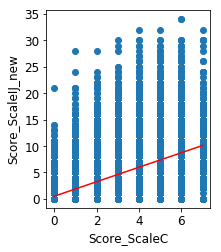

In [62]:
ax1 = plt.subplot(232)
gradient, intercept, r_value, p_value, std_err = stats.linregress(X_akeyC,Y_akey)
mn=np.min(X_akeyC)
mx=np.max(X_akeyC)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
ax1.scatter(X_akeyC,Y_akey)
ax1.plot(x1,y1,'-r')
ax1.set_xlabel('Score_ScaleC')
ax1.set_ylabel('Score_ScaleIJ_new')
plt.show()

In [63]:
#build linear regression models

X_akeyC = df_akey['Score_ScaleC']
Y_akey= df_akey["Score_ScaleIJ_new"]

## Scratch Part

In [64]:
# Figuring out how many nan entries there are in the original data
a = X_bkey.Score_ScaleA - X_bkey.Score_ScaleA

for col in cnames:
    a += X_bkey[col]
    
a.isna().sum()

0

In [65]:
# Data frame with only questionnaire responses

df_question =df.loc[:,"a1_combo":"EG85a"]
df_question['UniqueID'] = df['UniqueID']
cols = df_question.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_question = df_question[cols]
df_question.head()

,UniqueID,a1_combo,a2_combo,a3_combo,a4_combo,a5_combo,a6_combo,b7_combo,b8_combo,b9_combo,...,eg77_most,eg77_no_group,eg77_oldest,eg77_youngest,EG83a,EG83b,EG83c,EG83d,EG83e,EG85a
0,1010,1.0,5.0,3.0,1.0,1.0,1.0,3.0,5.0,3.0,...,,,,,,,,,,NaN
1,1010,4.0,3.0,2.0,1.0,2.0,1.0,3.0,2.0,2.0,...,18,,25,18,9,9,9,9,,9.0
2,1042,2.0,2.0,3.0,1.0,3.0,1.0,4.0,3.0,3.0,...,,,,,,,,,,NaN
3,1043,4.0,3.0,4.0,1.0,4.0,3.0,5.0,5.0,5.0,...,,,,,,,,,,NaN
4,1043,2.0,3.0,3.0,1.0,2.0,2.0,3.0,3.0,3.0,...,18,,26,15,1,0,0,1,,1.0


## Aviva's Code for Data Cleaning

In [ ]:
df['y_DateS1_Interview'] = pd.to_datetime(df['y_DateS1_Interview'], errors='coerce')
df = df.sort_values(by=['y_DateS1_Interview'])

df['y_TotalFactors'] = pd.to_numeric(df['y_TotalFactors'], downcast='integer', errors='coerce')
df.loc[(df['y_TotalFactors'] == 88), 'y_TotalFactors'] = np.nan

df['Age'] = pd.to_numeric(df['Age'], downcast='integer', errors='coerce')
df.loc[(df['Age'] == 99), 'Age'] = np.nan

df['AgeYSET'] = pd.to_numeric(df['AgeYSET'], errors='coerce')
df.loc[(df['AgeYSET'] == 0), 'AgeYSET'] = np.nan

df['YSET_I_R'] = pd.to_numeric(df['YSET_I_R'], errors='coerce')
df['y_YSET_IR_Recoded'] = pd.to_numeric(df['y_YSET_IR_Recoded'], errors='coerce')

df['ETO_ID'] = pd.to_numeric(df['ETO_ID'], errors='coerce')
df['NewRootID'] = df['NewRootID'].replace(' ',np.NaN)
df['OldRootID'] = df['OldRootID'].replace(' ',np.NaN)
df['UniqueID'] = df['ETO_ID']
df = df[key.index]

## Validate/Fill in Risk Factor
# Raw responses
# See README.md for explanation of which questions are included
RF_qs = key.loc['a1_combo':'ij42_6mos_combo'].index.tolist() + key.loc['ij43_ever_combo':'ij56_ever_combo'].index.tolist()
raw_qs = key.loc['a1_combo':'ij56_gang'].index.tolist() + key.loc['ck90':'EG86b'].index.tolist() + key.loc['gm57_6mos_combo':'gm60a'].index.tolist() + key.loc['h36_1_new':'P5_new'].index.tolist() + key.loc['xr_L72_awarenessXX':'xr_m71_codeXX'].index.tolist() 
for q in raw_qs:
    df[q] = pd.to_numeric(df[q], errors='coerce')
    
scale_scores = key.loc['Score_ScaleA':'Score_ScaleNorms'].index.tolist()
for score in scale_scores:
    df[score] = pd.to_numeric(df[score], errors='coerce')
    
scale_concerns = key.loc['ScoreA':'ScoreT'].index.tolist()
for concern in scale_concerns:
    df[concern] = pd.to_numeric(df[concern], errors='coerce')
    df.loc[(df[concern] == 7), concern] = np.nan
scale_concerns.append('ScoreK')
df['ScoreK'] = pd.to_numeric(df['ScoreK'], errors='coerce')
df.loc[(df['ScoreK'] == 4), 'ScoreK'] = np.nan
scale_concerns.append('ScoreGroupFriends')
df['ScoreGroupFriends'] = pd.to_numeric(df['ScoreGroupFriends'], errors='coerce')
df.loc[(df['ScoreGroupFriends'] == 4), 'ScoreGroupFriends'] = np.nan

scale_flags = key.loc['y_ARISK_NY':'y_TRISK_NY'].index.tolist()
for flag in scale_flags:
    df[flag] = pd.to_numeric(df[flag], errors='coerce')
    
def scale_score_calculate(df):
    scale_a = np.sum(df.loc[:,'a1_combo':'a6_combo'], axis=1).rename('scale_a')
    scale_b = np.sum(df.loc[:,'b7_combo':'b9_combo'], axis=1).rename('scale_b')
    scale_c = np.sum(df.loc[:,'c10_combo':'c16_combo'], axis=1).rename('scale_c')
    scale_de = np.sum(df.loc[:,'de17_combo':'de20_combo'], axis=1).rename('scale_de')
    scale_f = np.sum(df.loc[:,'f21_combo':'f26_combo'], axis=1).rename('scale_f')
    scale_g = np.sum(df.loc[:,'g27_combo':'g31_combo'], axis=1).rename('scale_g')
    scale_h = np.sum(df.loc[:,'h32_combo':'h37_combo'], axis=1).rename('scale_h')
    scale_ij = np.sum(df.loc[:,RF_qs[39:]], axis=1).rename('scale_ij')
    scale_t = np.add((df.loc[:,'t38_combo'] > 1).astype(int),(df.loc[:,'t39_combo'] > 1).astype(int)).rename('scale_t')
    
    # Not used for risk factor
    scale_fs = np.sum(df.loc[:,'FS91':'FS104'], axis=1).rename('scale_fs')
    scale_k = np.sum(df.loc[:,'k61':'k66'], axis=1).rename('scale_k')
    scale_m = np.sum(df.loc[:,'xr_m67_codeXX':'xr_m71_codeXX'], axis=1).rename('scale_m')
    scale_l = np.sum(df.loc[:,'xr_L72_awarenessXX':'xr_L75_awarenessXX'], axis=1).rename('scale_l')
    scale_p = np.sum(df.loc[:, 'P1_new':'P5_new'], axis=1).rename('scale_p')
    scale_norms = np.sum(df.loc[:, 'EG80':'EG85a'], axis=1).rename('scale_norms')
    # scale_conv uses xr_n90_groupXX, not computing at this time. (but if I were, I'd do it here.)
    
    df2 = pd.concat([scale_a, scale_b, scale_c, scale_de, scale_f, scale_g, scale_h, scale_ij, scale_t, scale_fs, scale_k, scale_m, scale_l, scale_p, scale_norms], axis=1)
    return df2

scale_scores_constructed = ['scale_a', 'scale_b', 'scale_c', 'scale_de', 'scale_f', 'scale_g', 'scale_h', 'scale_ij', 'scale_t', 'scale_fs', 'scale_k', 'scale_p', 'scale_norms'] #skipping M and L because it doesn't exist in the dataset

calculated_scores = scale_score_calculate(df)
different = (df[scale_scores].values != calculated_scores[scale_scores_constructed].values)

for i in range(len(scale_scores_constructed)):
    print(scale_scores_constructed[i], np.sum(different, axis=0)[i])


## Check if all values of a key are covered
#target = 'ReferralSource'
#all_data = pd.to_numeric(df[target], errors='coerce')
#info = key[key['key']==target]
#values = literal_eval(info['values'].max())
#value_keys = [i[0] for i in values]
#
#present = all_data[np.isin(all_data, value_keys)]
#missing = all_data[~np.isin(all_data, value_keys)]
###test = df['y_YSET_InterviewDateRecorded']
##
##old = pd.read_csv('../data/YSET_Database_January_2014_Decebmer_2017_Clean_Data.csv')

## Compare YSET_I_R with y_YSET_IR_Recoded
# Number crunching
#intake_IR = sum(df['YSET_I_R'] < 10)
#retake_IR = sum(df['YSET_I_R'] >= 10)
#intake_recoded = sum(df['y_YSET_IR_Recoded'] == 1)
#retake_recoded = sum(df['y_YSET_IR_Recoded'] == 2)
#matching_IR = sum((df['YSET_I_R'] < 10) & (df['y_YSET_IR_Recoded'] == 1)) + sum((df['YSET_I_R'] >= 10) & (df['y_YSET_IR_Recoded'] == 2))
#can_fill = sum((df['YSET_I_R'] < 10) & (df['y_YSET_IR_Recoded'].isnull())) + sum((df['YSET_I_R'] >= 10) & (df['y_YSET_IR_Recoded'].isnull())) + sum((df['YSET_I_R'].isnull()) & (df['y_YSET_IR_Recoded'] == 1)) + sum((df['YSET_I_R'].isnull()) & (df['y_YSET_IR_Recoded'] == 2))

# Repopulate as many entries as possible (4)
df.loc[(df['YSET_I_R'] < 10) & (df['y_YSET_IR_Recoded'].isnull()), 'y_YSET_IR_Recoded'] = 1

# Drop all conflicting entries (56)
df = df.drop(df[(df['YSET_I_R'] < 10) & (df['y_YSET_IR_Recoded'] == 2)].index)
df = df.drop(df[(df['YSET_I_R'] >= 10) & (df['y_YSET_IR_Recoded'] == 1)].index)
df = df.dropna(subset=['YSET_I_R', 'y_YSET_IR_Recoded'])

## Construct UniqueID
#  1. From ETO_ID (high confidence of accuracy)
df.loc[(df['UniqueID'] == 0), 'UniqueID'] = np.nan
df.loc[(df['UniqueID'] == 88888), 'UniqueID'] = np.nan
df.loc[(df['UniqueID'] == 99999), 'UniqueID'] = np.nan

#current_count = sum(df['UniqueID'].notnull())  # 28,436

#  2. Recover missing ETO_ID using matching NewRootID entries, then OldRootID entries
def fill_nan(df, key='NewRootID', target='UniqueID'):
    df.loc[df.dropna(subset=[key]).index, target] = df.dropna(subset=[key]).groupby([key])[target].fillna(method='backfill')
    df.loc[df.dropna(subset=[key]).index, target] = df.dropna(subset=[key]).groupby([key])[target].fillna(method='ffill')
    return df

df = fill_nan(df, key='NewRootID', target='UniqueID')
#current_count = sum(df['UniqueID'].notnull()) # 28,478
df = fill_nan(df, key='OldRootID', target='UniqueID')
#current_count = sum(df['UniqueID'].notnull()) # 28,690

## If the same identifier has Y1s associated with it, drop all but the first
def drop_duplicate_Y1(df, key='ETO_ID'):
    test = (df[df['YSET_I_R'] == 1][key].duplicated(keep='first')) & (df[df['YSET_I_R'] == 1][key].notnull()) & ~(df['YSET_I_R'] != 1)
#    print(sum(test))
    df = df[~test]
    return df

df = drop_duplicate_Y1(df, key='UniqueID')    # drop 95
df = drop_duplicate_Y1(df, key='NewRootID')   # drop 8
df = drop_duplicate_Y1(df, key='OldRootID')   # drop 81

# Assign a four digit number to Y1 entries (guaranteed to correspond to one person due to previous steps)
number_assigned = df.loc[(df['YSET_I_R']==1) & (df['UniqueID'].isnull()),'UniqueID'].shape[0]
df.loc[(df['YSET_I_R']==1) & (df['UniqueID'].isnull()),'UniqueID'] = range(1000, number_assigned + 1000)

# Fill in corresponding Yn and Rn responses for the new UniqueIDs using RootID values
df = fill_nan(df, key='NewRootID', target='UniqueID')
#current_count = sum(df['UniqueID'].notnull())  # 34,298
df = fill_nan(df, key='OldRootID', target='UniqueID')
current_count = sum(df['UniqueID'].notnull()) # 36,017

df = df.dropna(subset=['UniqueID'])
df = df.dropna(subset=RF_qs) # If the questions are not filled in, we must drop

# If the risk factor is not recorded in 'y_TotalFactors', add it.
def calculate_RF(df):
    age_ind=df.loc[:,'Age']>12
    scale_a = (np.sum(df.loc[:,'a1_combo':'a6_combo'], axis=1) > 15).astype(int)
    scale_b = (np.sum(df.loc[:,'b7_combo':'b9_combo'], axis=1) > 6).astype(int)
    scale_c = (np.sum(df.loc[:,'c10_combo':'c16_combo'], axis=1) > 3).astype(int)
    scale_de = (np.sum(df.loc[:,'de17_combo':'de20_combo'], axis=1) > 13).astype(int)
    scale_f = (np.sum(df.loc[:,'f21_combo':'f26_combo'], axis=1) > 18).astype(int)
    scale_g = (np.sum(df.loc[:,'g27_combo':'g31_combo'], axis=1) > 12).astype(int)
    scale_h = (np.sum(df.loc[:,'h32_combo':'h37_combo'], axis=1) > 11).astype(int) # age difference
    scale_h[age_ind] = (np.sum(df.loc[age_ind,'h32_combo':'h37_combo'], axis=1) > 13).astype(int)
    t38 = df.loc[:,'t38_combo'] > 1
    t39 = df.loc[:,'t39_combo'] > 1
    scale_t = (t38 | t39).astype(int)
    scale_ij = np.sum(df.loc[:,'ij40_6mos_combo':'ij56_ever_combo'], axis=1) > 3 # age difference
    scale_ij[age_ind] = np.sum(df.loc[age_ind,'ij40_6mos_combo':'ij56_ever_combo'], axis=1) > 5
            
    return (scale_a + scale_b + scale_c + scale_de + scale_f + scale_g + scale_h + scale_t + scale_ij)

test = df.dropna(subset=['y_TotalFactors'])
test2 = test[test['y_TotalFactors'] != calculate_RF(test)]['y_TotalFactors']
print(test2.value_counts())

df = df.sort_values(by=['UniqueID', 'y_DateS1_Interview'])
df.to_csv('../data/YSET_Dec2008_Dec2019_cleaned20190531.csv', columns=key.index)